In [11]:
import pandas as pd 
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random
import requests
import pandas as pd
import numpy as np
from datetime import date

#### DS1 Final Project 

### Determinants of a Trendy YouTube Video 

#### Lexi Gu


### Background 

#### YouTube is the most popular platform for people to share and view original contents.
- more than 2 billion users 
- one billion hours and 5 billion videos watched daily

#### There are more and more content-creators emerging 
- popularity 
- profits 


#### What makes a YouTube Video popular?
- What factors contribute to the popularity of YouTube Videos?
- category?
- tags?
- publish date?
- Likes? Dislikes? Comment?
- number of newly confirmed Covid cases/deaths?

#### I would like to examine the factors that are predictive of "popularity" on the YouTube platform


#### Methods I have used 
- Downloaded and Scraped Data
- Data cleaning 
- Merging Data 
- Two visualizations for correlations using seaborn and matplotlib 

#### Data  Files 
- Two csv files for Trendy YouTube videos in the US & UK
- Two json files for video category id and title 
- Scraped Covid data (daily new cases and deaths)

In [13]:
# load the CSV files for the US and UK youtube videos
us_video = pd.read_csv("US_youtube_trending_data.csv")
uk_video = pd.read_csv("BR_youtube_trending_data.csv")

# load the json files 
us_category = pd.read_json("US_category_id.json")
uk_category = pd.read_json("BR_category_id.json")

# save the link to the website 
url = "https://covidtracking.com/data/national/chart-tables"

# scrape the web content 
raw = requests.get(url)

# check the connection 
raw.status_code

# generate a temporary table 
tables = pd.read_html(raw.text)

newcases = tables[1]
newcases.rename(columns = {'Value':'new_case'}, inplace = True)

newdeath = tables[3]
newdeath.rename(columns = {'Value':'new_death'}, inplace = True)

In [18]:
# drop the unnecessary column in the category data set 
us_category = us_category['items']
uk_category = uk_category['items']

# create an empty dataframe for matching id and category title 
id_title = pd.DataFrame()

# create an empty list for us category id 
id_us = []

# create an empty list for us category title 
title_us = []
# append the id extracted from the us category to the list 
for i in range(len(us_category)):
    id_us.append(us_category[i]['id'])

# append the title extracted from the us category to the list 
for i in range(len(us_category)):
    title_us.append(us_category[i]['snippet']['title'])
    
# assign the lists to columns in the id_title dataframe 
id_title['category_id'] = id_us
id_title['category_title'] = title_us



# create an empty dataframe for matching id and category title 
id_title_uk = pd.DataFrame()

# create an empty list for us category id 
id_uk = []

# create an empty list for us category title 
title_uk = []
# append the id extracted from the us category to the list 
for i in range(len(uk_category)):
    id_uk.append(uk_category[i]['id'])

# append the title extracted from the us category to the list 
for i in range(len(uk_category)):
    title_uk.append(uk_category[i]['snippet']['title'])
    
# assign the lists to columns in the id_title dataframe 
id_title_uk['category_id'] = id_uk
id_title_uk['category_title'] = title_uk

###### Merged all the files 
- To associate each category number in the csv file with the category title in the json files 
- For furthur manipulation, cleaning, and comparison for the whole dataset at once (US & UK)

###### Cleaning
- Made a bar chart to check NA values and extracted rows with NA values 
- Changed string to datetime objects 
- Groupby the video id to count trending days, view increase, like increase, and comment increase  
- Counted the difference in days between the publish date and trending date 
- Dropped the duplicates by video id 

###### Visualizations 
- Bar chart 
- Scatterplot 

###### Results (dataframe & visualizations)
- One large dataframe containing YouTube Videos in the US & UK
- One covid dataset containing date, new cases, and new deaths
- One bar chart for category counts in the video dataset 
- One scatterplot visualizing the correlation between view counts and date

In [20]:
# change the column name in the video dataframe 
us_video = us_video.rename(columns = {'categoryId':'category_id'})
uk_video = uk_video.rename(columns = {'categoryId':'category_id'})

# change the data type 
id_title['category_id'] = id_title['category_id'].astype("int")
id_title_uk['category_id'] = id_title['category_id'].astype("int")

# merge the id_title with video dataframe
us_video = us_video.merge(id_title, how = 'inner', on = 'category_id')
uk_video = uk_video.merge(id_title_uk, how = 'inner', on = 'category_id')

# Create a new column indicating the region
us_video['region'] = 'us'
uk_video['region'] = 'uk'

# merge the two dataset 
total = pd.concat([us_video,uk_video])
total = total.reset_index(drop = True)

In [24]:
# create an empty list for trending_date and publish date
trending = []
publish = []

# change to datetime object 
for i in range(len(total['trending_date'])):
    temp_trend = total['trending_date'][i].split('T')
    trend = datetime.strptime(temp_trend[0],'%Y-%m-%d')
    trending.append(trend)

for i in range(len(total['publishedAt'])):
    temp_publish = total['publishedAt'][i].split('T')
    publish1 = datetime.strptime(temp_publish[0],'%Y-%m-%d')
    publish.append(publish1)
    
# assign the datetime object back to the dataframe 
total['trending_date'] = trending
total['publishedAt'] = publish

In [26]:
# count the trending days 
trending_days = total.groupby('video_id')['trending_date'].agg(['max','min']).reset_index()
trending_days['trending_days'] = trending_days['max'] - trending_days['min']

# count the view increase 
view_increase = total.groupby('video_id')['view_count'].agg(['max','min']).reset_index()
view_increase['view_increase'] = view_increase['max'] - view_increase['min']

# count the like increase 
like_increase = total.groupby('video_id')['likes'].agg(['max','min']).reset_index()
like_increase['like_increase'] = like_increase['max'] - like_increase['min']

# count the comment increase 
comment_increase = total.groupby('video_id')['comment_count'].agg(['max','min']).reset_index()
comment_increase['comment_increase'] = comment_increase['max'] - comment_increase['min']


In [27]:
# merge the increases and trending days 
trending_period = trending_days.merge(view_increase, how = 'inner', on = 'video_id')
trending_period = trending_period.merge(like_increase, how = 'inner', on = 'video_id')
trending_period = trending_period.merge(comment_increase, how = 'inner', on = 'video_id')
trending_period = trending_period[['video_id','trending_days','view_increase','like_increase','comment_increase']]

# merge the trending period info with the main dataset 
total = total.merge(trending_period, how = 'inner', on = 'video_id')

In [28]:
# count the difference in days between published date and trending date 
published = total['publishedAt'].to_list()
trendy = total['trending_date'].to_list()

# assign to column 
total['diff_days'] = [x1 - x2 for (x1, x2) in zip(trendy, published)]

# drop the unnecessary columns and re-arrange the order 
total = total[['video_id','title','channelTitle','tags','category_id','category_title','publishedAt','trending_date','diff_days','trending_days','view_count','view_increase','likes','like_increase','dislikes','comment_count','comment_increase','comments_disabled','ratings_disabled','region']]

In [32]:
# drop the duplicates 
total_unique = total.drop_duplicates('video_id')

In [31]:
# merge the new cases and new deaths 
covid = newcases.merge(newdeath, how = 'inner', on = 'Date')

# drop unnecessary columns 
covid = covid[['Date','new_case','new_death']]

In [34]:
total_unique

,video_id,title,channelTitle,tags,category_id,category_title,publishedAt,trending_date,diff_days,trending_days,view_count,view_increase,likes,like_increase,dislikes,comment_count,comment_increase,comments_disabled,ratings_disabled,region
0,3C66w5Z0ixs,I ASKED HER TO BE MY GIRLFRIEND...,Brawadis,brawadis|prank|basketball|skits|ghost|funny vi...,22,People & Blogs,2020-08-11,2020-08-12,1 days,6 days,1514614,2443612,156908,47352,5855,35313,10261,False,False,us
7,49Z6Mv4_WCA,i don't know what im doing anymore,CaseyNeistat,[None],22,People & Blogs,2020-08-11,2020-08-12,1 days,5 days,940036,1049619,87111,47984,1860,7052,2933,False,False,us
13,nt3VVyv5pxQ,Try Not To Laugh Challenge #51,Smosh Pit,smosh|smosh pit|smosh games|funny|comedy,22,People & Blogs,2020-08-11,2020-08-12,1 days,5 days,591837,358083,44168,12707,409,2652,635,False,False,us
19,BNeDH6UTmXw,Ten Minutes with Tyler Cameron | Q&A,Tyler Cameron,the bachelor|the bachelorette|Tyler c|Tyler Ca...,22,People & Blogs,2020-08-11,2020-08-12,1 days,4 days,105955,78556,4511,1628,69,673,178,False,False,us
24,gPdUslndvVI,Our Farm Got Destroyed.,Cole The Cornstar,farming|family farm|agriculture|agriculture jo...,22,People & Blogs,2020-08-11,2020-08-12,1 days,5 days,277338,520534,37533,16056,197,3666,1091,False,False,us
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43967,6X1c91KX_5Q,O MAIOR PROJETO DA MINHA VIDA,Tiago Fonseca,tiago fonseca|nego grana|como ficar rico|como ...,19,Travel & Events,2020-10-25,2020-10-26,1 days,5 days,42882,48214,7301,4134,115,497,135,False,False,uk
43972,45cJjkM3rL0,NÃO ACREDITO QUE ELES ABANDONARAM ESSAS MALAS ...,Isabela Borges,isabela|isabela borges|isaborgesh|intercambio ...,19,Travel & Events,2020-11-19,2020-11-20,1 days,5 days,198657,74883,16999,3882,496,0,0,True,False,uk
43977,FcwOHdNUMck,LIVE SHOP ROMMANEL PRESENTE SEMPRE COM SIMONE ...,Simone e Simaria,simone|simone mendes|simaria|simaria mendes|si...,19,Travel & Events,2020-11-21,2020-11-24,3 days,3 days,708511,20868,27594,424,479,462,27,False,False,uk
43981,eM8jpKLUsBo,Diana Noble 30 dia de uso do Suplemento,Canal do Vaqueiro Atualizado,Cavalo|vaqueiro|boi|égua|cawboy|horse|Fazenda|...,15,Pets & Animals,2020-09-21,2020-09-22,1 days,4 days,61901,22017,7336,1308,71,283,28,False,False,uk


[None, None, None, None]

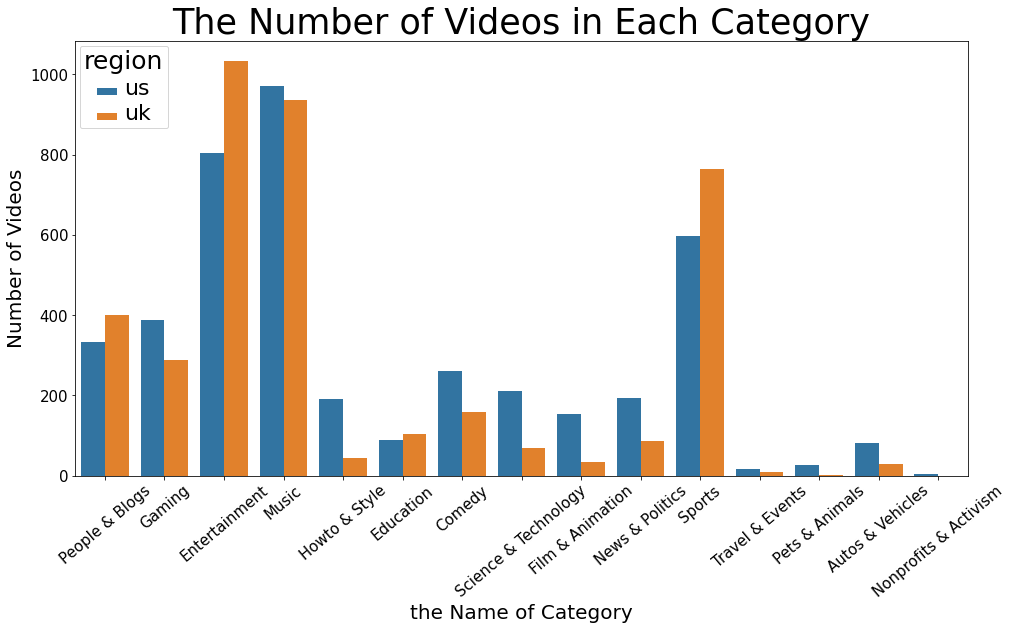

In [48]:
# Visualization 1 - Bar Chart  
plt.figure(figsize = (16,8))
fig = sns.countplot('category_title', hue = 'region', data = total_unique)
fig.set_title('The Number of Videos in Each Category', fontsize = 35)
fig.set_xlabel('the Name of Category', fontsize = 20)
fig.set_ylabel('Number of Videos', fontsize = 20)
fig.set_xticklabels(fig.get_xticklabels(), rotation = 40)
fig.tick_params(labelsize = 15)
plt.setp(fig.get_legend().get_title(), fontsize='25')
plt.setp(fig.get_legend().get_texts(), fontsize='22')

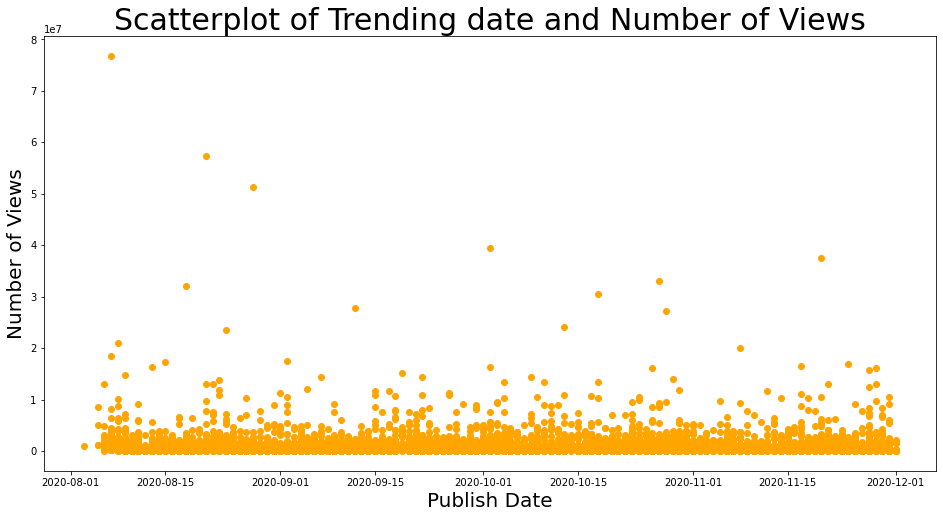

In [54]:
# Visualization 2 - Scatter plot 
plt.figure(figsize = (16,8))
plt.scatter(x = total_unique['publishedAt'],y = total_unique['view_count'],color = 'orange')
plt.title('Scatterplot of Trending date and Number of Views', fontsize = 30)
plt.xlabel("Publish Date", fontsize = 20)
plt.ylabel("Number of Views", fontsize = 20)
fig2 = plt.gca()
fig2.set_xticks(fig2.get_xticks()[::1])

##### Methods I am considering using 
- Data: cleaning, merging, and creating new columns 
- Visualizations
- Statistical learning algorithms 

#### Data and Visulizations 
- Clean the covid data scraped from the web 
- Merge it with the main dataset 
- Count net likes, make it as a new column 
- Make a line chart for covid cases and the views 
- Make a heatmap for correlations among all variables 
- Make scatter plots for the variable that is most strongly correlated with view counts 

#### Statistical Learning algorithms 
- Decide the Y and Xs based on previous visualizations 
- deploy different statistical learning algorithems for comparison 
- Identify which model performed the best using ROC curve 

#### Lessons and Challenges 
- Noticed the duplicated after cleaning, merging, and after I made visualizations (biased vis)
- Hard to define the popularity on YouTube (Views? Trending days?)

### Thank you for listening. 